<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x, language='english')) < 32]
        )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [27]:
print("Всего предложений:", len(sentences))

Всего предложений: 198756


Посчитаем для каждого слова его встречаемость.

In [8]:
import string

words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = sentence.translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/198756 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря

for word, cnt in words.most_common(vocab_size):
        vocab.add(word)

In [10]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [28]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [29]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [30]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [31]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [32]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)
# исправлена ошибка в строке выше: sentences -> eval-sentences
train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [33]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [35]:
def train_model(model, num_epoch, criterion, optimizer, dataloader):

    losses = []
    perplexities = []
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, dataloader))

    return losses, perplexities


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 n_layers: int,
                 dropout_rate=0.20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.norm = nn.LayerNorm(hidden_dim) # слой LayerNorm

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.norm(self.linear(self.non_lin(output)))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))

        return projection

# Посмотрим на RNN с одним слоем и слабой регуляризацией (dropout_rate = 0.1) и провалидируем ее на валидационном датасете

In [44]:
model_0 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), n_layers=1, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_0 = torch.optim.Adam(model_0.parameters())
n_epoch = 9

In [45]:
losses_0, perplexities_0 = train_model(model_0, n_epoch, criterion, optimizer_0, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

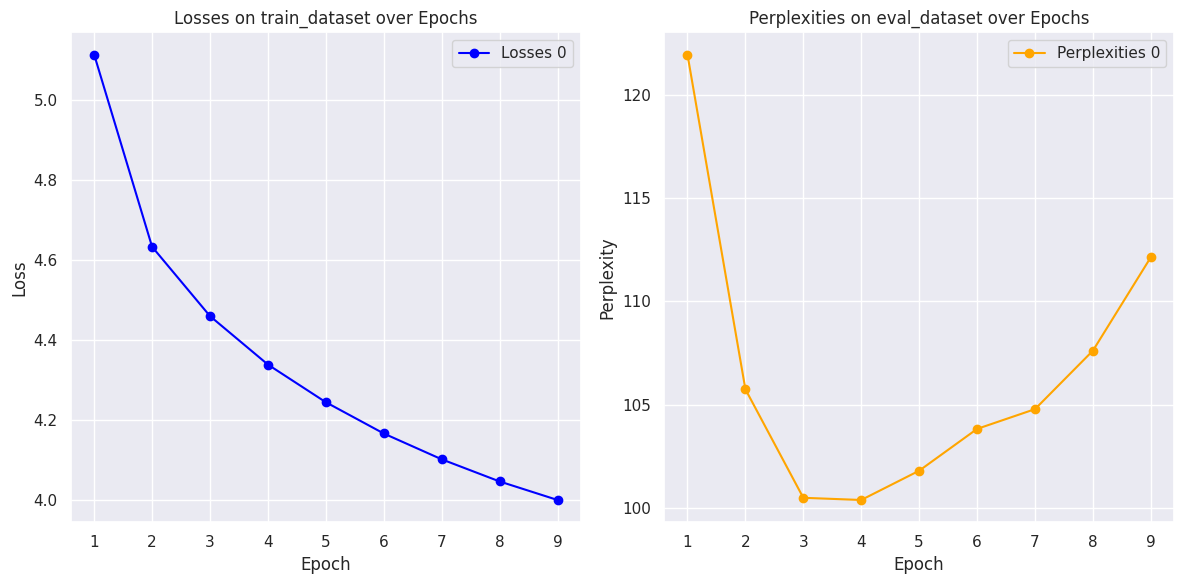

In [46]:
epochs = range(1, len(losses_0) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_0, label='Losses 0', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_0, label='Perplexities 0', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Посмотрим на RNN с одним слоем и стандартной регуляризацией и провалидируем ее на валидационном датасете

In [48]:
model_1 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), n_layers=1, dropout_rate=0.20).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_1 = torch.optim.Adam(model_1.parameters())
n_epoch = 9

In [49]:
losses_1, perplexities_1 = train_model(model_1, n_epoch, criterion, optimizer_1, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

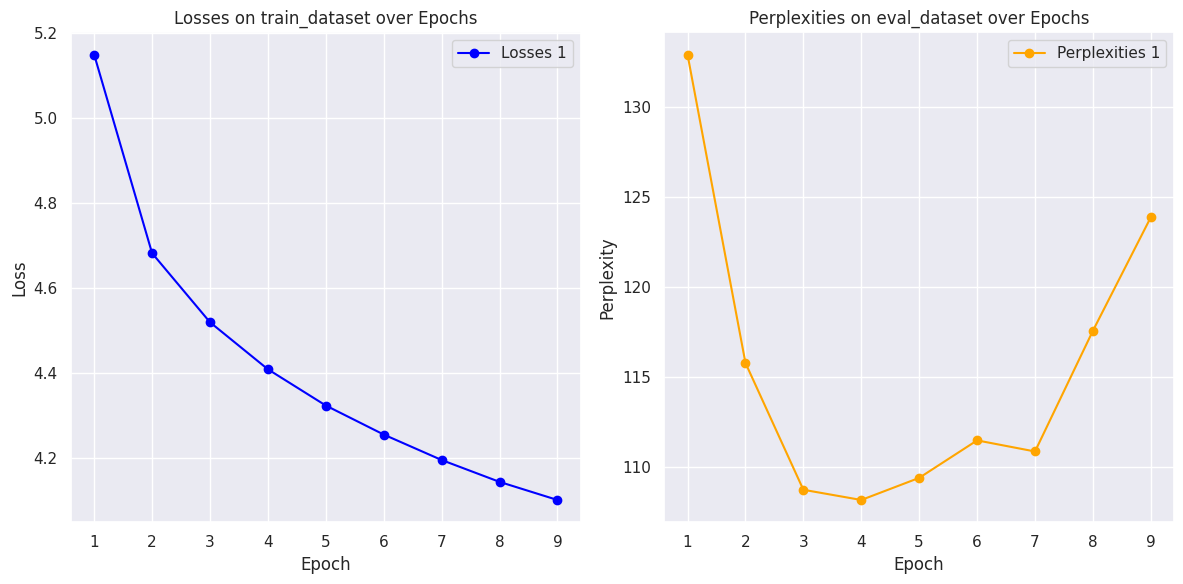

In [50]:
epochs = range(1, len(losses_1) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_1, label='Losses 1', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_1, label='Perplexities 1', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Теперь посмотрим модель, с двумя слоями и dropout_rate=0.1 ,и провалидируем так же на валидационном датасете

In [51]:
model_2 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), n_layers=2, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_2 = torch.optim.Adam(model_2.parameters())
n_epoch = 7

In [52]:
losses_2, perplexities_2 = train_model(model_2, n_epoch, criterion, optimizer_2, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

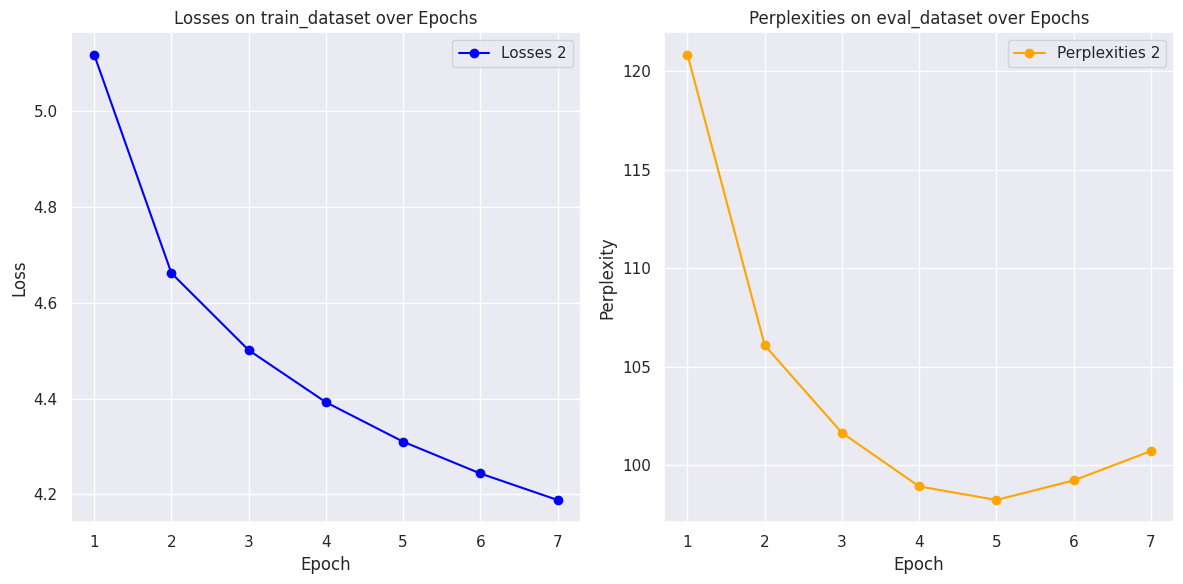

In [53]:
epochs = range(1, len(losses_2) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_2, label='Losses 2', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_2, label='Perplexities 2', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Финальная модель 1-го эксперимента: 2 RNN слоя с dropout_rate = 0.1, и LayerNorm с оптимальным количеством эпох обучения
# А так же проверка качества перплексии на тестовом датасете

In [54]:
model_3 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), n_layers=2, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_3 = torch.optim.Adam(model_3.parameters())
n_epoch = 5

In [55]:
losses_3, perplexities_3 = train_model(model_3, n_epoch, criterion, optimizer_3, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

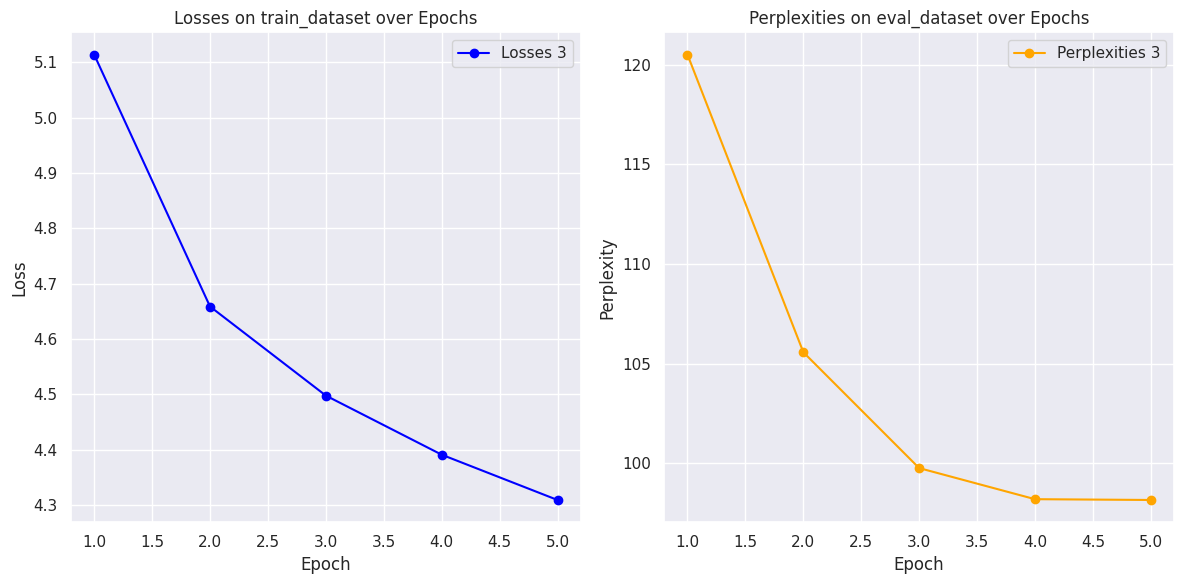

In [56]:
epochs = range(1, len(losses_3) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_3, label='Losses 3', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_3, label='Perplexities 3', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

In [57]:
perplex = evaluate(model_3, criterion, test_dataloader)
print(f'Перплексия на тестовом датасете равна: {perplex}')

Перплексия на тестовом датасете равна: 99.72634486663036


# Перплексия на тестовом датасете равна: 99.72634486663036

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [20]:
class LanguageModelNew(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 n_layers: int,
                 bidirectional: bool,
                 dropout_rate=0.10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, 
                           hidden_dim, 
                           num_layers=n_layers,  
                           batch_first=True, 
                           dropout=0.1,
                           bidirectional=bidirectional
                           )
        self.linear = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.norm = nn.LayerNorm(hidden_dim) # слой LayerNorm

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.norm(self.linear(self.non_lin(output)))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))

        return projection

# Модель LSTM, регуляризация и количество слоев не изменены

In [22]:
model_4 = LanguageModelNew(hidden_dim=256, vocab_size=len(vocab), n_layers=2, dropout_rate=0.1, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_4 = torch.optim.Adam(model_4.parameters())
n_epoch = 10

In [23]:
losses_4, perplexities_4 = train_model(model_4, n_epoch, criterion, optimizer_4, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

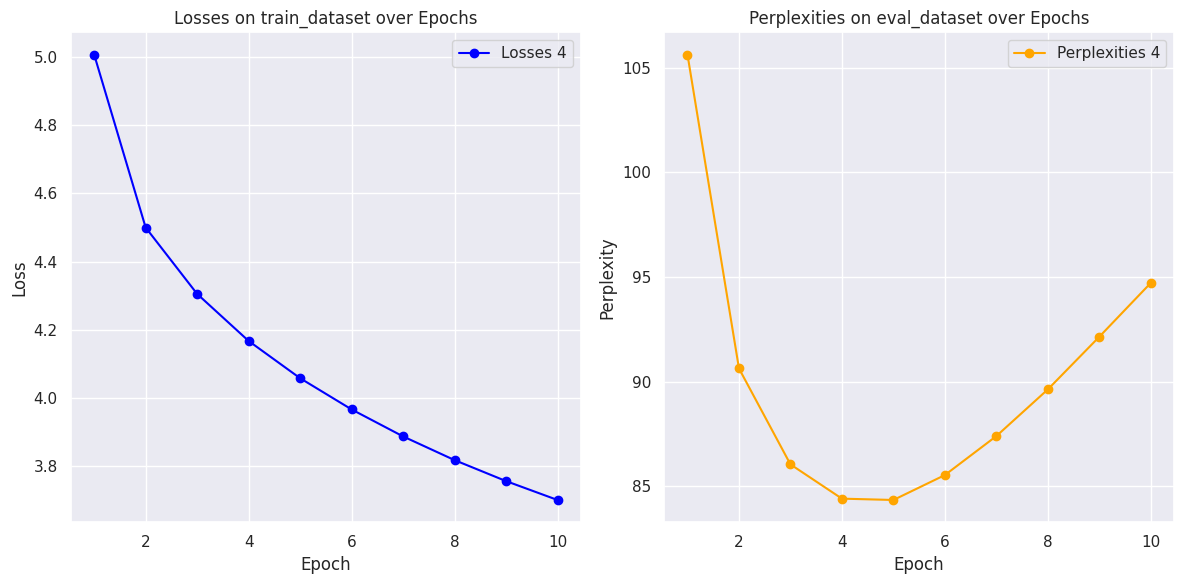

In [24]:
epochs = range(1, len(losses_4) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_4, label='Losses 4', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_4, label='Perplexities 4', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Модель LSTM, hidden dim = 512, регуляризация и количество слоев не изменены

In [58]:
model_5 = LanguageModelNew(hidden_dim=512, vocab_size=len(vocab), n_layers=2, dropout_rate=0.1, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_5 = torch.optim.Adam(model_5.parameters())
n_epoch = 8

In [59]:
losses_5, perplexities_5 = train_model(model_5, n_epoch, criterion, optimizer_5, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

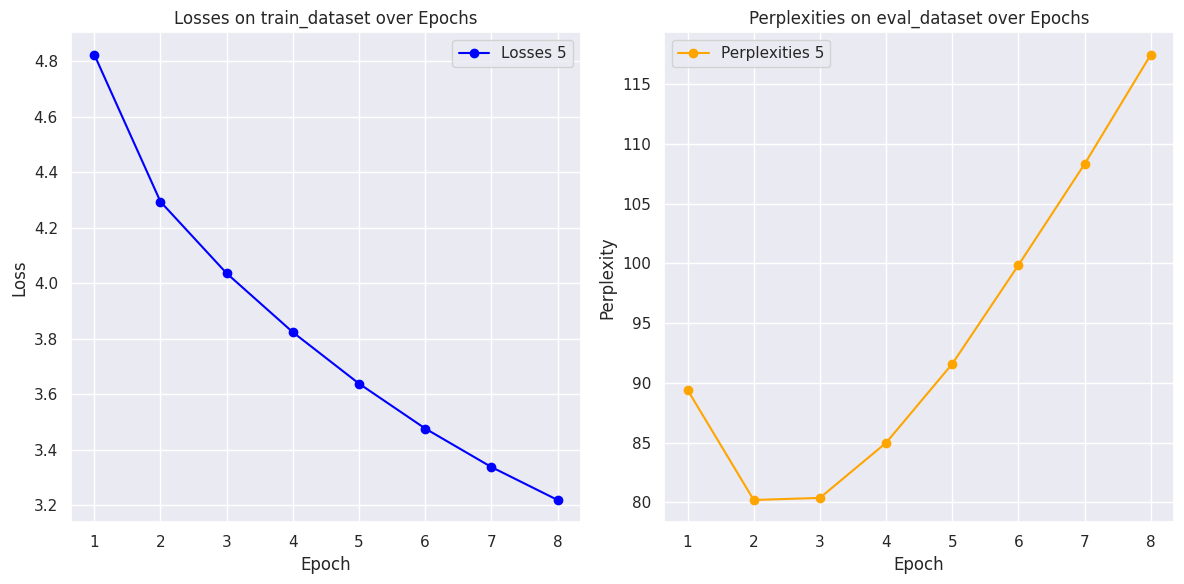

In [60]:
epochs = range(1, len(losses_5) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_5, label='Losses 5', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_5, label='Perplexities 5', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Модель LSTM, hidden dim = 400, dropout_rate = 0.2, количество слоев не изменено

In [63]:
model_6 = LanguageModelNew(hidden_dim=400, vocab_size=len(vocab), n_layers=2, dropout_rate=0.2, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_6 = torch.optim.Adam(model_6.parameters())
n_epoch = 5

In [64]:
losses_6, perplexities_6 = train_model(model_6, n_epoch, criterion, optimizer_6, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

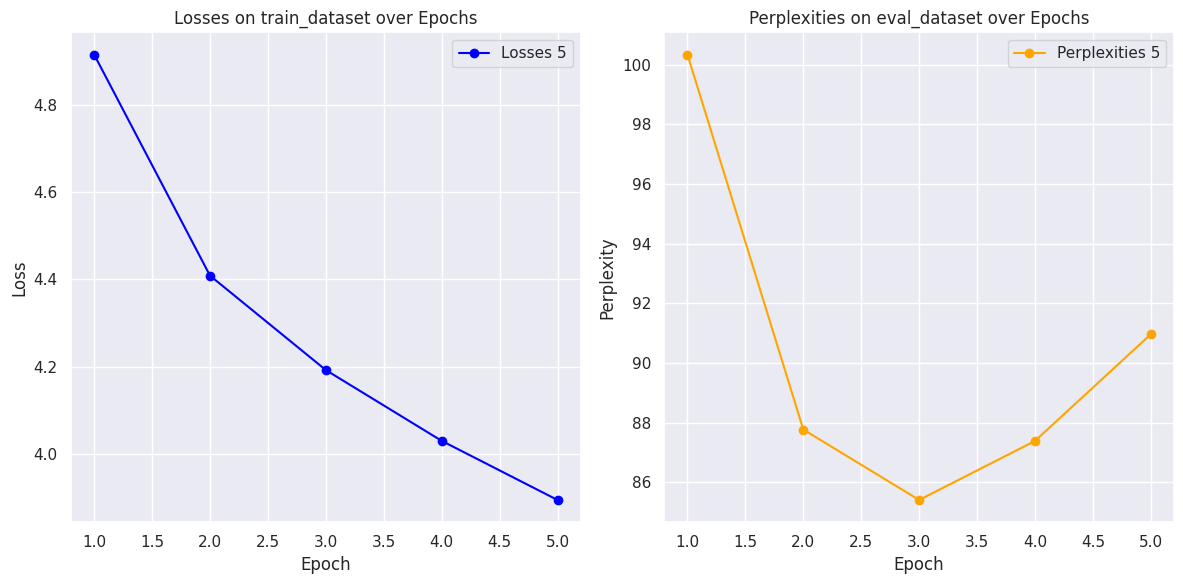

In [65]:
epochs = range(1, len(losses_6) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_6, label='Losses 5', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_6, label='Perplexities 5', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Модель LSTM, hidden dim = 300, dropout_rate = 0.1, количество слоев 3

In [98]:
model_7 = LanguageModelNew(hidden_dim=300, vocab_size=len(vocab), n_layers=3, dropout_rate=0.1, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_7 = torch.optim.Adam(model_7.parameters())
n_epoch = 5

In [ ]:
losses_7, perplexities_7 = train_model(model_7, n_epoch, criterion, optimizer_7, eval_dataloader)

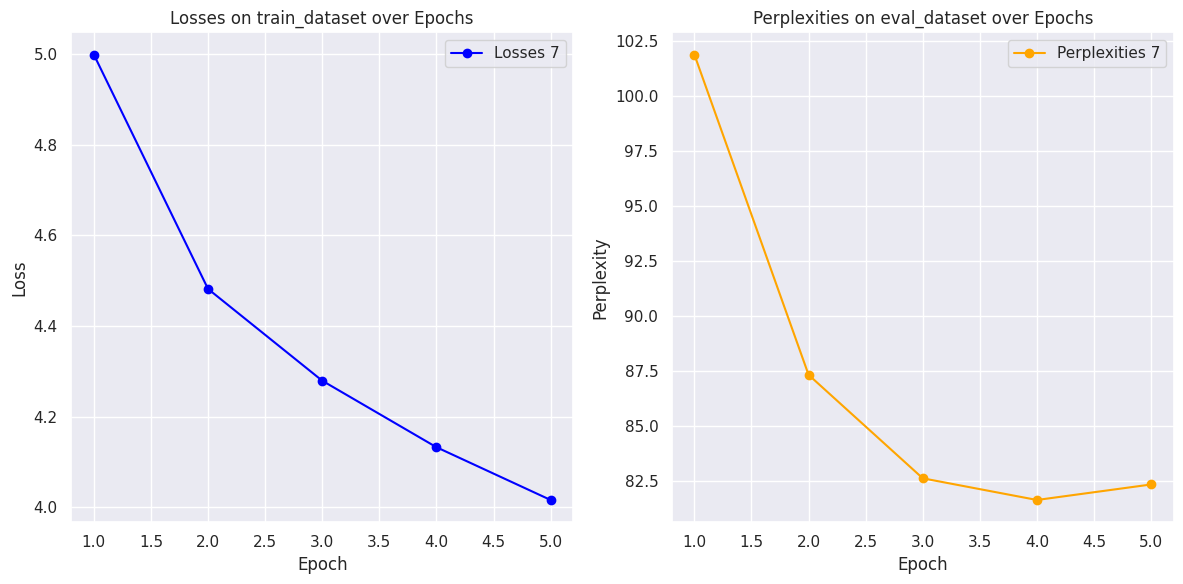

In [85]:
epochs = range(1, len(losses_7) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_7, label='Losses 7', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_7, label='Perplexities 7', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Модель LSTM, hidden dim = 512, dropout_rate = 0.25, количество слоев 3

In [100]:
model_8 = LanguageModelNew(hidden_dim=512, vocab_size=len(vocab), n_layers=3, dropout_rate=0.25, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_8 = torch.optim.Adam(model_8.parameters())
n_epoch = 4

In [101]:
losses_8, perplexities_8 = train_model(model_8, n_epoch, criterion, optimizer_8, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

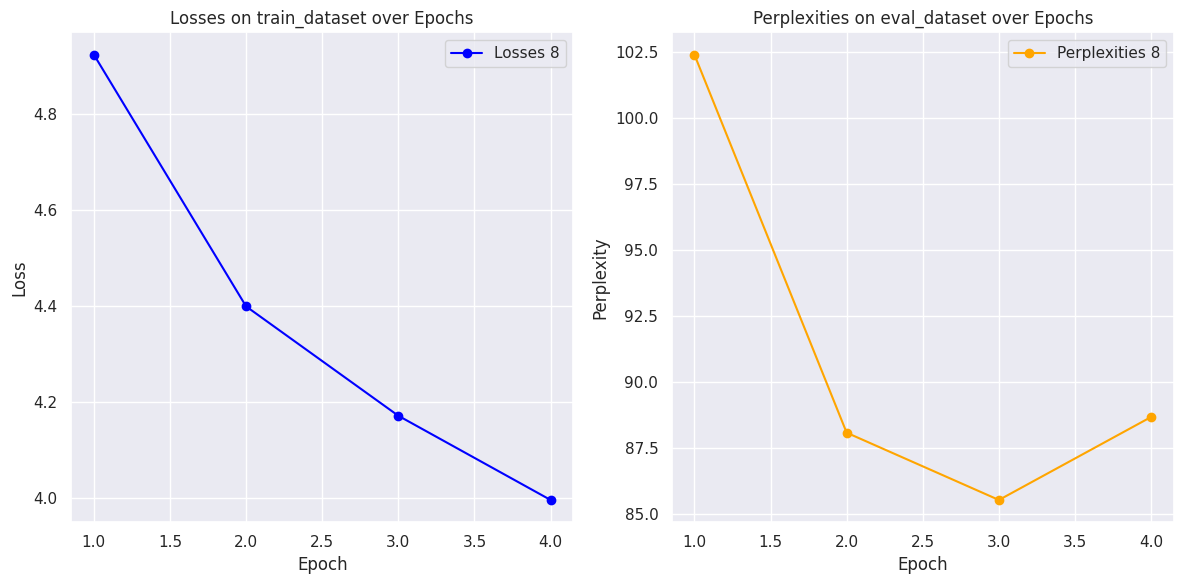

In [102]:
epochs = range(1, len(losses_8) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_8, label='Losses 8', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_8, label='Perplexities 8', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

# Финальная модель: возьмем LSTM, hidden dim = 300, dropout_rate = 0.1, количество слоев 3 с оптимальным количеством эпох

In [103]:
model_9 = LanguageModelNew(hidden_dim=300, vocab_size=len(vocab), n_layers=3, dropout_rate=0.1, bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_9 = torch.optim.Adam(model_9.parameters())
n_epoch = 4

In [104]:
losses_9, perplexities_9 = train_model(model_9, n_epoch, criterion, optimizer_9, eval_dataloader)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

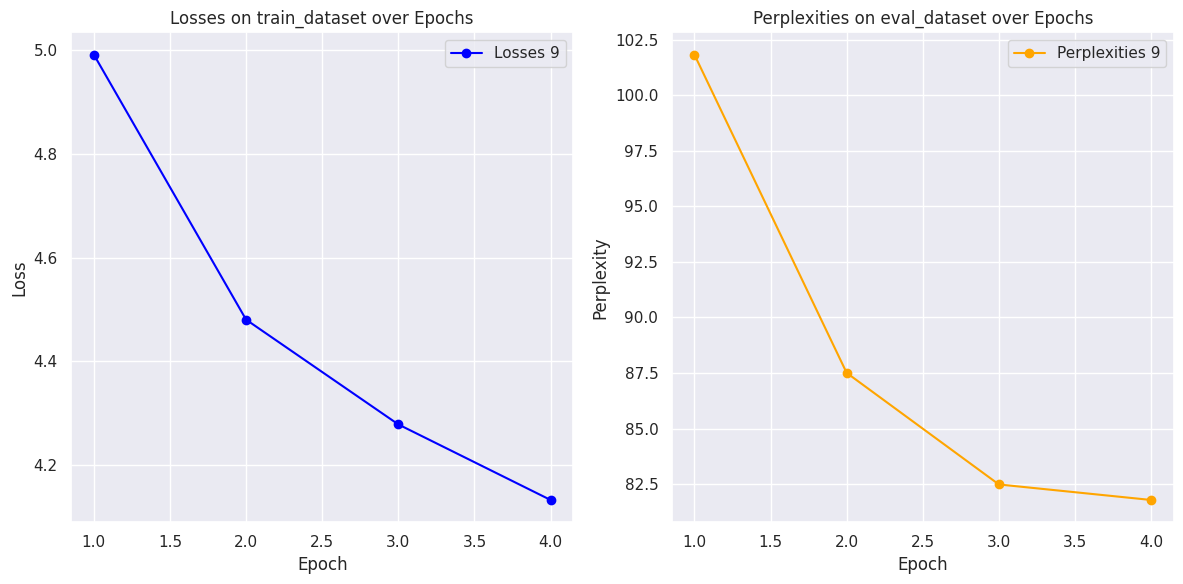

In [105]:
epochs = range(1, len(losses_9) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epochs, losses_9, label='Losses 9', marker='o', color='blue')
axs[0].set_title('Losses on train_dataset over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, perplexities_9, label='Perplexities 9', marker='o', color='orange')
axs[1].set_title('Perplexities on eval_dataset over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
plt.tight_layout()
plt.show()

In [106]:
perplex = evaluate(model_9, criterion, test_dataloader)
print(f'Перплексия на тестовом датасете равна: {perplex}')

Перплексия на тестовом датасете равна: 82.79699809734637


# Перплексия на тестовом датасете равна: 82.79699809734637

# Погенерируем текст!

In [137]:
def generate_text(model, start_sequence, vocab, max_length=10, temperature=1.0, device="cpu"):
    model.eval()  
    current_sequence = start_sequence

    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.LongTensor([current_sequence]).to(device)
            output = model(input_tensor)
            output = output[:, -1, :].div(temperature).exp().cpu()
            next_token = torch.multinomial(output, 1).item()
            current_sequence.append(next_token)

    generated_text = ' '.join([ind2word[token] for token in current_sequence])
    return generated_text

start_sequence = [57,89]  # Начальная последовательность, например, начало предложения
generated_text = generate_text(model_9, start_sequence, vocab, device="cuda" if torch.cuda.is_available() else "cpu")
print(generated_text)

hoovergod left out and tried to build an audience to find any


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [1]:
import pandas as pd

test_perplexity1 = 99.726
test_perplexity2 = 82.796

df = pd.DataFrame({
    'Experiment': ['Experiment 1', 'Experiment 2'],
    'Test Perplexity': [test_perplexity1, test_perplexity2]
})

print(df)

     Experiment  Test Perplexity
0  Experiment 1           99.726
1  Experiment 2           82.796


# Отчет:
- В первом эксперименте проводился подбор гиперпараметров модели с простыми RNN слоями на валидационном датасете. Сначала была протестирована однослойная модель со слабой регуляризацией. По графику перплексии видно быстрое переобучение модели, поэтому в следующей модели регуляризация(dropout_rate) была повышена, но значительных результатов от этого шага не было. Далее была рассмотрена модель в двумя слоями, ее перплексия оказалась значительно лучше, чем у однослойной,поэтому за финальную модель первого эксперимента взята именно она,разумеется, обученная на оптимальном количестве эпох, чтобы избежать переобучения.
- Во втором эксперементе ислледовалась на влидационном датасете модель, использующая LSTM слои. Результаты с ней, очевидно, лучше. Сначала рассматривалась модель с теми же параметрами, что и финальная с первого эксперимента. Она показала, хорошее качество. Поэтому в следующей модели был увеличен hidden_dim, но данный шаг очень быстро привел к переобучению модели без значимого роста в качестве. Из-за чего было принято решение слегка уменьшить hidden_dim, и увеличить регуляризацию для борьбы с переобучением. Результаты оказались не значительными. Далее количество слоев модели было увеличено до 3-х, hidden_dim = 300, dropout_rate = 0.1. Данная модель считается оптимальной среди всех в двух экспериментах (взята за финальную с оптимальным количеством эпох). Также была еще одна попытка с увеличением hidden_dim до 512 с большим dropout_rate,но у успеху она не привела
- Итак, можно сделать несколько общих выводов. На данном корпусе и моделях такой архитектуры переобучение наступает довольно скоро,хотя используються такие методы регуляризации, как LayerNorm, Dropout. Увеличение dropout_rate не дает желаемого, а лишь немного режет качество. LSTM явно оказалась лидером при любых гиперпараметрах. Финальные модели были проверены на тестовых датасетах, и наилучшим значением перплексии оказалось 82.796.
- Для того, чтобы получить качество лучше, можно продолжить подбор оптимальных параметров, но на данной задаче, конечно же, лучше было бы использовать более современные архитектуры.